In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import joblib


In [5]:

# Load training data
train_data = pd.read_csv('../main_dataset.csv')
train_low = train_data[train_data['Id'] <= 1e-15]


train_high = train_data[train_data['Id'] > 1e-15]






In [6]:

# Prepare features and target for low current model
X_low = train_low[['Tox','Nc', 'Nd', 'Ns', 'Vds', 'Vgs']]
y_low = np.log10(train_low['Id'])

# Prepare features and target for high current model
X_high = train_high[['Tox','Nc', 'Nd', 'Ns', 'Vds', 'Vgs']]
y_high = np.log10(train_high['Id'])

# Polynomial and scaling transformation
poly_low= PolynomialFeatures(degree=3, include_bias=False)
poly_high = PolynomialFeatures(degree=3, include_bias=False)

scaler_low = StandardScaler()
scaler_high = StandardScaler()

X_low_poly = poly_low.fit_transform(X_low)
X_low_scaled = scaler_low.fit_transform(X_low_poly)

# Transform and scale for high current model
X_high_poly = poly_high.fit_transform(X_high)  # Reuse the fitted polynomial features
X_high_scaled = scaler_high.fit_transform(X_high_poly)  # Reuse the fitted scaler

# # Train the XGBoost models
model_low = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=7, random_state=42, n_jobs=-1)
model_high = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=7, random_state=42, n_jobs=-1)

model_low.fit(X_low_scaled, y_low)
model_high.fit(X_high_scaled, y_high)

# Save the trained models
joblib.dump(model_low, 'xgboost_model_low.joblib')
joblib.dump(model_high, 'xgboost_model_high.joblib')


# model_low = joblib.load('xgboost_model_low.joblib')
# model_high = joblib.load('xgboost_model_high.joblib')




['xgboost_model_high.joblib']

407    5.590000e-18
408    7.050000e-16
409    5.650000e-18
410    5.400000e-18
411    5.370000e-18
           ...     
598    7.460000e-18
599    7.500000e-18
600    7.330000e-18
601    7.390000e-18
602    7.390000e-18
Name: Id, Length: 196, dtype: float64
[6.9516019e-15 4.5380862e-15 4.2555139e-15 2.5291694e-15 5.3102367e-15
 6.1525327e-15 5.9879207e-15 6.8194716e-15 5.7343080e-15 6.8682691e-15
 7.8521581e-15 8.0401807e-15 8.8611818e-15 9.0078532e-15 9.1617396e-15
 8.9468795e-15 7.6110391e-15 6.9117524e-15 6.9117524e-15 6.9117524e-15
 6.9117524e-15 6.9117524e-15 6.9660883e-15 7.2616346e-15 6.5472530e-15
 7.0019907e-15 6.5879368e-15 7.3697804e-15 9.2962027e-15 9.3239049e-15
 9.8711898e-15 1.1364955e-14 1.2594491e-14 1.1646757e-14 1.2659346e-14
 1.2659346e-14 1.3134858e-14 1.3248323e-14 1.3248323e-14 1.3660919e-14
 1.3975969e-14 1.3842343e-14 1.4266232e-14 1.4729180e-14 1.5196935e-14
 1.5196935e-14 1.6456381e-14 1.5328720e-14 1.5250926e-14 1.6247190e-14
 1.6457430e-14 1.7013399e-14 1.5

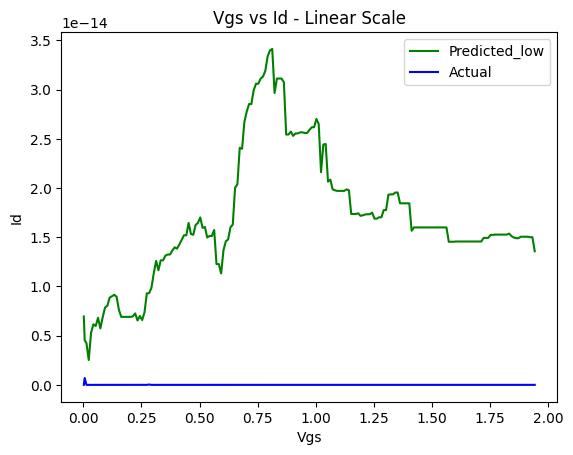

-------------


In [9]:

# Load test data


from sklearn.metrics import mean_absolute_error

test_dataset = pd.read_csv('../main_dataset.csv').iloc[407:603]

test_features = test_dataset[['Tox','Nc', 'Nd', 'Ns', 'Vds', 'Vgs']]

def predict_current(test_features):
    
    
    # # Prepare data for Model 1 (low current values)
    # row_low = scaler_low.transform(poly_low.transform([row]))
    # pred_low = model_low.predict(row_low)[0]
    
    x_low = scaler_low.transform(poly_low.transform(test_features))
    x_high = scaler_high.transform(poly_high.transform(test_features))

    predict_low_log = model_low.predict(x_low)
    predict_high_log = model_high.predict(x_high)

    predict_high = np.power(10, predict_high_log)  
    predict_low = np.power(10, predict_low_log)

    predict_high = np.where(predict_high < 1e-15, 0, predict_high)

    predict_low = np.where(predict_low > 1e-15, 0, predict_low )
    

    predictions = np.where(predict_high ==0, predict_low, predict_high )
    print(predictions)
    return predictions

print(test_dataset['Id'])
predictions = predict_current(test_features)
print(r2_score(predictions, test_dataset['Id']))
# # Evaluation
# print("R² Score low:", r2_score(test_dataset['Id'], predictions[0] ))
# print("mae -1  low_model  : " , mean_absolute_error(test_dataset['Id'], predictions[0] ))
# print("R² Score  high :", r2_score(test_dataset['Id'], predictions[1] ))

# print("mae -2  high_model : ", mean_absolute_error(test_dataset['Id'], predictions[1] ))



# Plotting
plt.plot(test_features['Vgs'], predictions, color="green", label="Predicted_low")
# plt.plot(test_features['Vgs'], predictions, color="red", label="Predicted_high")

plt.plot(test_features['Vgs'], test_dataset['Id'], color="blue", label="Actual", )
plt.title('Vgs vs Id - Linear Scale')
plt.xlabel('Vgs')
plt.ylabel('Id')
# plt.ylim(0, 1e-15)
plt.legend()
plt.show()

print("-------------")
